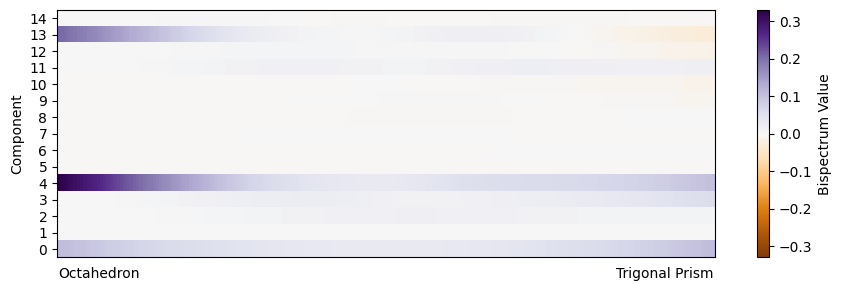

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [1]:
import os
import sys
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.ticker as ticker

# Add src directory to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

from utils.plotters import visualize_geometry, colorplot, visualize_signal, compare_geometries, compare_four_geometries
from utils.geometries import octahedron, trigonal_prism, see_saw, square_plane, tetrahedron
import spectra
from spectra import sum_of_diracs, bispectrum

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)


def interpolate_geometries(geom1, geom2, n):
    """
    Linearly interpolate between two geometries.
    
    Parameters:
    geom1: First geometry (array of vertices)
    geom2: Second geometry (array of vertices)
    n: Number of interpolated geometries to return (including start and end)
    
    Returns:
    List of n geometries interpolated between geom1 and geom2
    """
    # Ensure we have at least 2 interpolated geometries
    n = max(2, n)
    
    # Create parameter values from 0 to 1
    t_values = jnp.linspace(0, 1, n)
    
    # Create a list to store interpolated geometries
    interpolated_geometries = []
    
    # For each parameter value
    for t in t_values:
        # Linear interpolation: geom1 + t * (geom2 - geom1)
        interpolated_geom = geom1 + t * (geom2 - geom1)
        interpolated_geometries.append(interpolated_geom)
    
    return jnp.array(interpolated_geometries)

geometries = interpolate_geometries(octahedron, trigonal_prism, 200)

compute_bispectrum = lambda x: bispectrum(sum_of_diracs(x, lmax=4))

bispectra = jax.vmap(compute_bispectrum)(geometries)

def plot_bispectra_interpolation(bispectra):
    """
    Create a colorplot of bispectra vectors across the geometry interpolation.
    
    Parameters:
    bispectra: Array of shape (n_steps, n_components) containing bispectrum values
    """
    # Create figure with reduced height
    plt.figure(figsize=(9, 3))
    
    # Determine the color scale limits symmetrically around zero
    max_abs_val = jnp.max(jnp.abs(bispectra))
    
    # Create the colorplot/heatmap with PuOr colormap
    im = plt.imshow(bispectra.T, aspect='auto', interpolation='nearest', 
                   cmap='PuOr', origin='lower',
                   vmin=-max_abs_val, vmax=max_abs_val)
    
    # Add a colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Bispectrum Value')
    
    # Set y-axis label
    plt.ylabel('Component')
    
    # Remove x-axis ticks and numbers
    plt.xticks([], [])
    
    # Add labels for the start and end geometries
    plt.text(0, -1.5, 'Octahedron', ha='left', va='center')
    plt.text(bispectra.shape[0]-1, -1.5, 'Trigonal Prism', ha='right', va='center')
    
    # Adjust y-ticks to show component indices
    plt.yticks(range(bispectra.shape[1]))
    
    # Tight layout
    plt.tight_layout()
    plt.show()
    
    return plt.gcf()

# Call the function with the bispectra data
plot_bispectra_interpolation(bispectra)

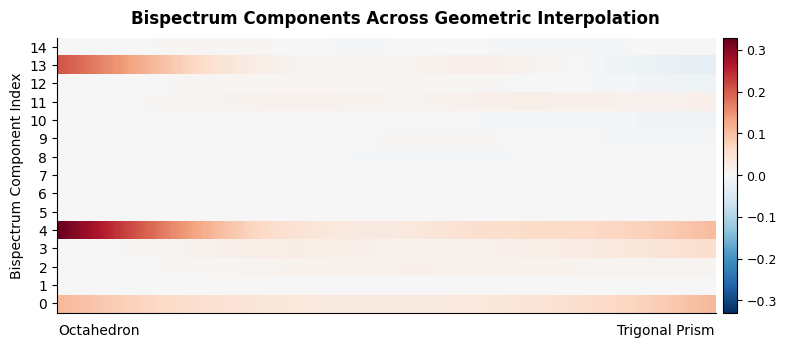

In [2]:
def plot_bispectra_interpolation(bispectra, geom1_name="Octahedron", geom2_name="Trigonal Prism", 
                                 save_path=None, show_plot=True):
    """
    Create a publication-ready colorplot of bispectra vectors across geometry interpolation.
    
    Parameters:
    bispectra: Array of shape (n_steps, n_components) containing bispectrum values
    geom1_name: Name of the first geometry
    geom2_name: Name of the second geometry
    save_path: Path to save the figure (if None, doesn't save)
    show_plot: Whether to display the plot
    
    Returns:
    The figure object
    """
    # Create figure with a specific size
    fig = plt.figure(figsize=(8, 3.5))
    
    # Create a layout with proper margins
    gs = gridspec.GridSpec(1, 1, figure=fig)
    ax = fig.add_subplot(gs[0, 0])
    
    # Determine the color scale limits symmetrically around zero
    max_abs_val = jnp.max(jnp.abs(bispectra))
    
    # Create the colorplot/heatmap with a scientific colormap (RdBu_r)
    im = ax.imshow(bispectra.T, aspect='auto', interpolation='none', 
                   cmap='RdBu_r', origin='lower',
                   vmin=-max_abs_val, vmax=max_abs_val)
    
    # Add a colorbar with scientific formatting
    cbar = fig.colorbar(im, ax=ax, pad=0.01, fraction=0.046, aspect=20)
    cbar.ax.tick_params(labelsize=9)
    
    # If there are many components, don't show every tick
    n_components = bispectra.shape[1]
    if n_components > 20:
        # Show fewer ticks for clarity
        step = max(1, n_components // 10)
        yticks = range(0, n_components, step)
        yticklabels = [str(i) for i in yticks]
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
    else:
        # Show all component indices
        ax.set_yticks(range(n_components))
    
    # Set y-axis label
    ax.set_ylabel('Bispectrum Component Index')
    
    # Remove x-axis ticks
    ax.set_xticks([])
    
    # Add geometry labels directly on plot
    xtick_locs = [0, bispectra.shape[0]-1]
    xtick_labels = [geom1_name, geom2_name]
    
    for idx, (loc, label) in enumerate(zip(xtick_locs, xtick_labels)):
        # Position the text below the axis
        horizontal_align = 'left' if idx == 0 else 'right'
        ax.text(loc, -1.5, label, ha=horizontal_align, va='center', 
                fontsize=10, fontweight='normal')
    
    # Add title above the plot
    plt.suptitle("Bispectrum Components Across Geometric Interpolation", 
                fontsize=12, fontweight='bold', y=0.98)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Tight layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    
    # Save figure if a path is provided
    if save_path:
        # Save in multiple formats
        plt.savefig(f"{save_path}.pdf", dpi=600, bbox_inches='tight')
        plt.savefig(f"{save_path}.png", dpi=600, bbox_inches='tight')
    
    # Display or close
    if show_plot:
        plt.show()
    else:
        plt.close()
    
    return fig

# Call the function with the bispectra data
_ = plot_bispectra_interpolation(bispectra, save_path="bispectrum_interpolation")

In [8]:
# Set random seed for reproducibility
np.random.seed(1)

# Generate a random quaternion for rotation
from scipy.spatial.transform import Rotation as R
random_quat = R.random().as_quat()
random_rotation = R.from_quat(random_quat)

geometry_1 = geometries[0]
geometry_2 = geometries[67]
geometry_3 = geometries[133]
geometry_4 = geometries[199]

geometry_1 = geometry_1 / jnp.max(jnp.linalg.norm(geometry_1, axis=1))
geometry_2 = geometry_2 / jnp.max(jnp.linalg.norm(geometry_2, axis=1))
geometry_3 = geometry_3 / jnp.max(jnp.linalg.norm(geometry_3, axis=1))
geometry_4 = geometry_4 / jnp.max(jnp.linalg.norm(geometry_4, axis=1))

rotated_geometry_1 = random_rotation.apply(geometry_1)
rotated_geometry_2 = random_rotation.apply(geometry_2)
rotated_geometry_3 = random_rotation.apply(geometry_3)
rotated_geometry_4 = random_rotation.apply(geometry_4)

compare_four_geometries(rotated_geometry_1, '0', rotated_geometry_2, '67', rotated_geometry_3, '133', rotated_geometry_4, '199', lmax=6, show_points=False)


# compare_four_geometries(geometries[0], '0', geometries[67], '67', geometries[133], '133', geometries[199], '199', lmax=8, show_points=False)

/var/folders/7c/7cx32s8x1x32j9xw0z_x3y980000gn/T/ipykernel_66875/2205833342.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


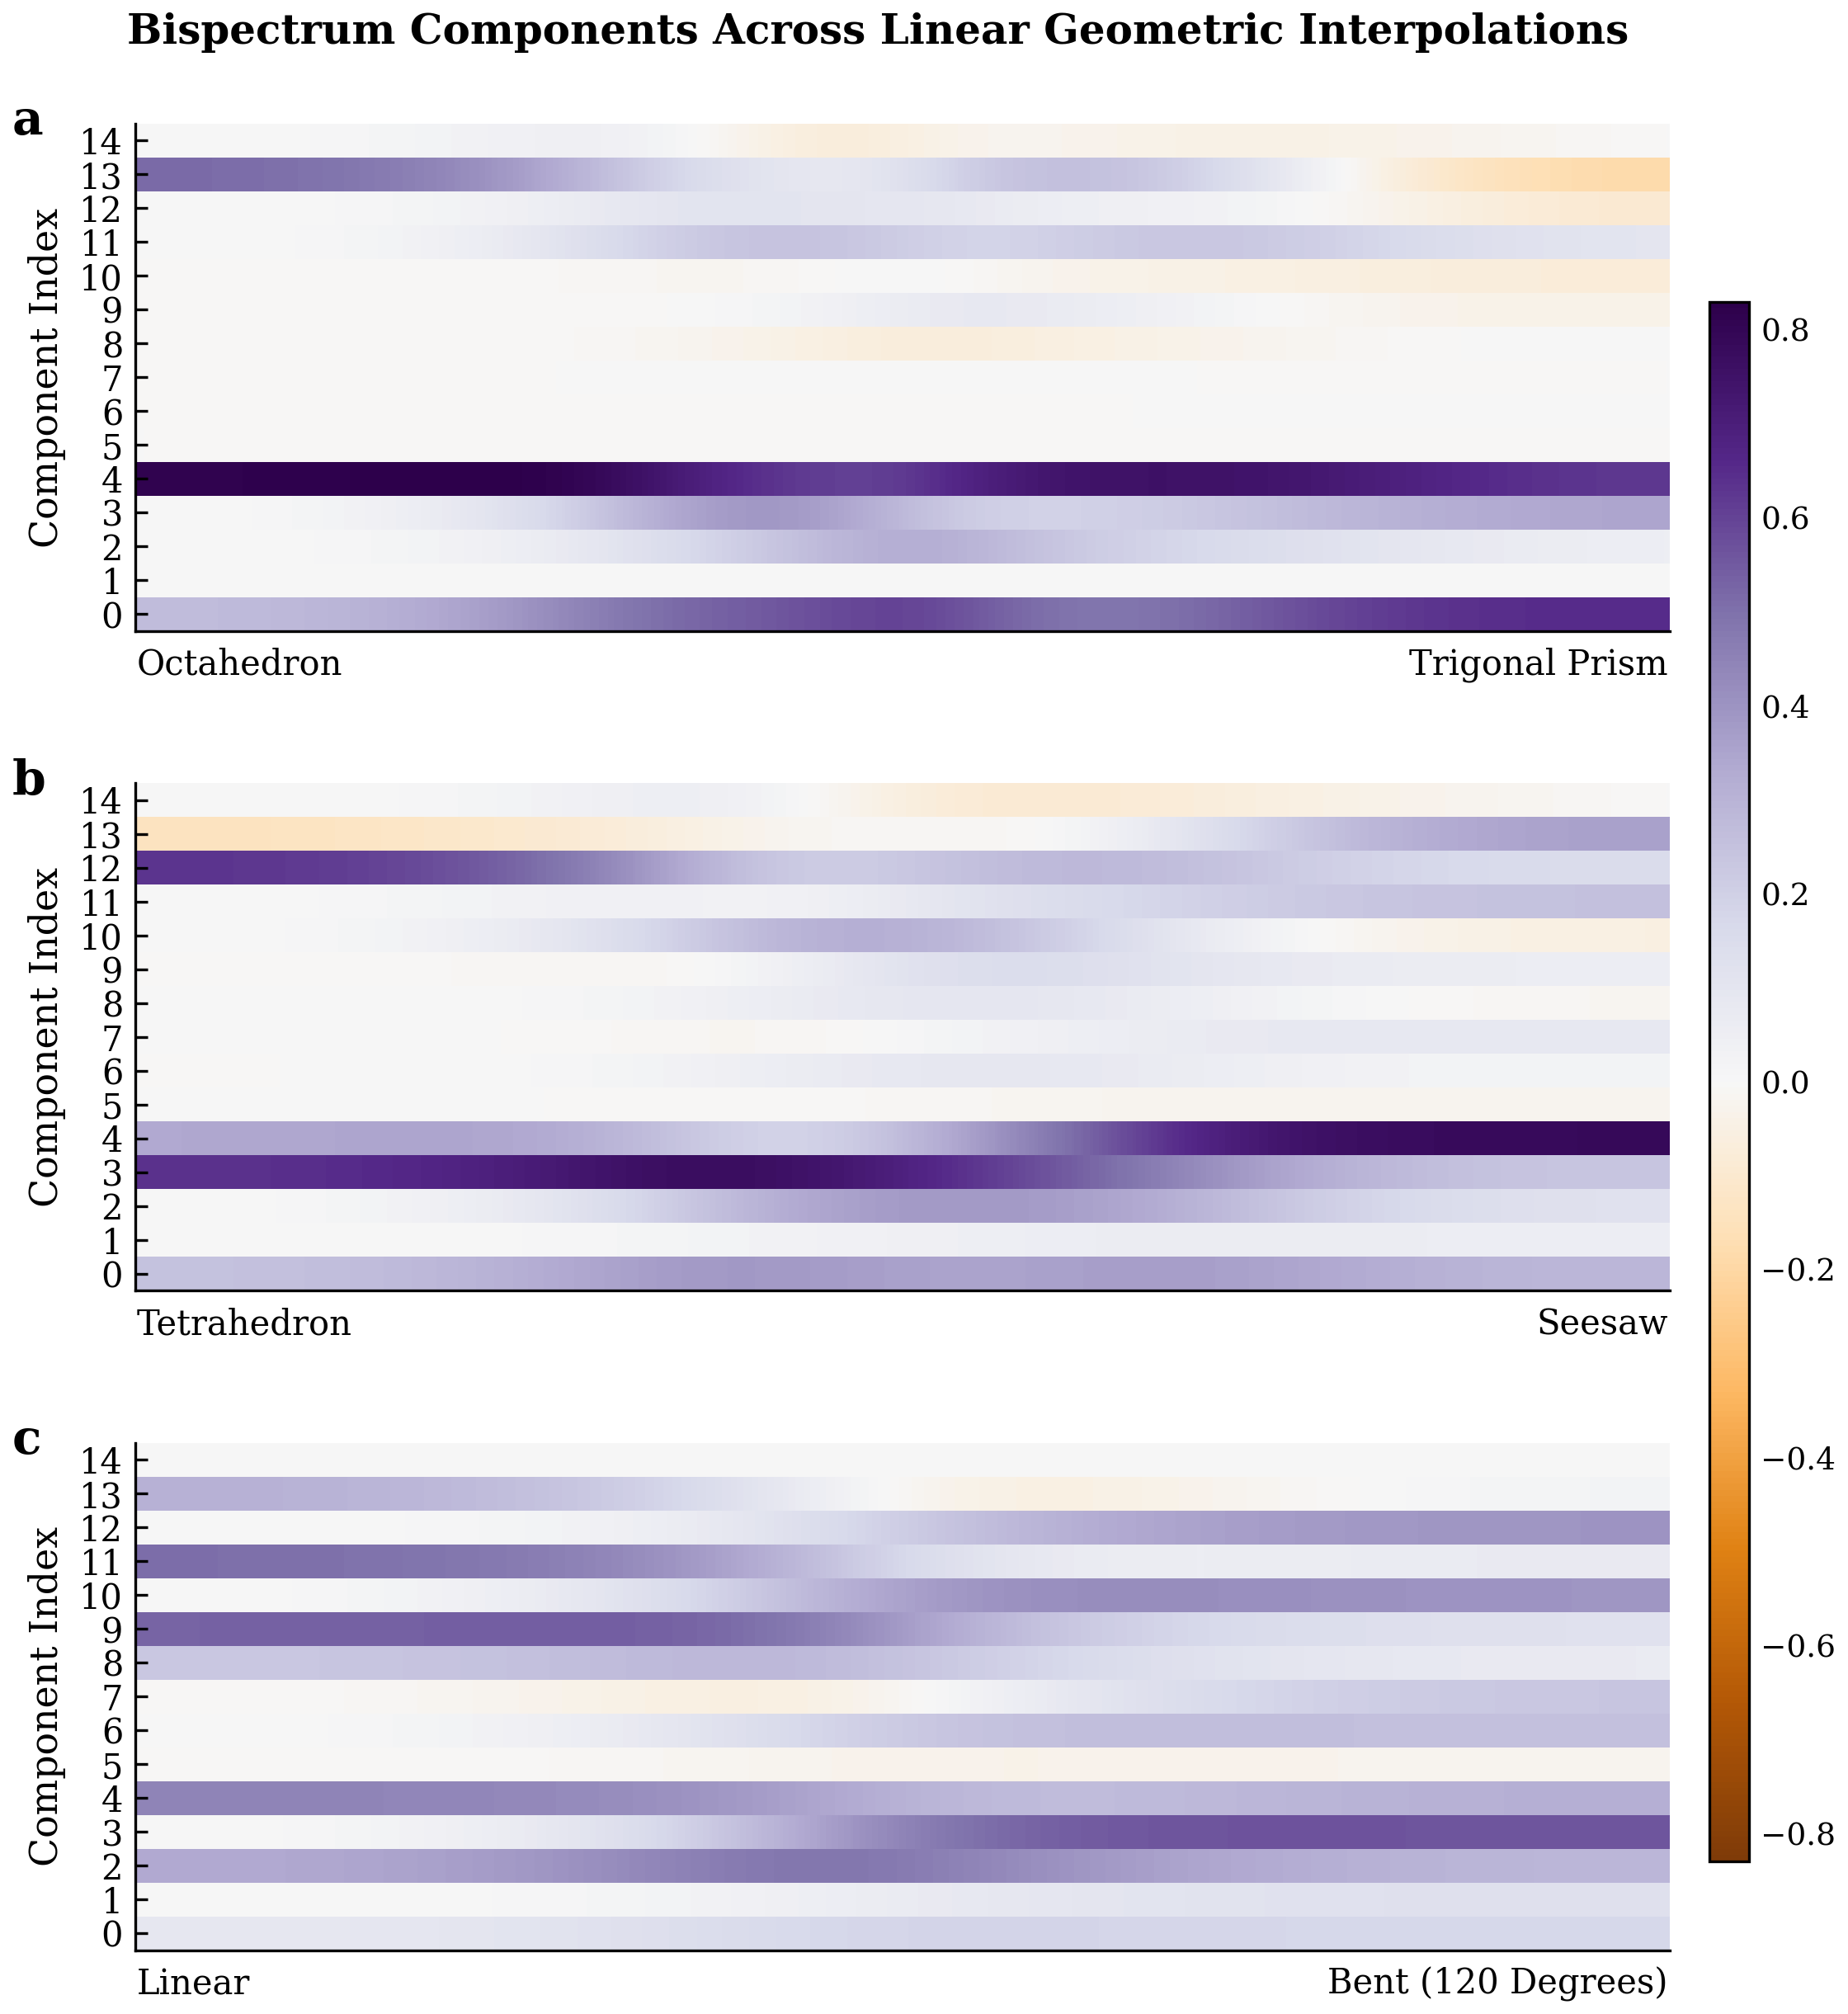

In [20]:
import os
import sys
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.ticker as ticker

# Add src directory to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

from utils.plotters import visualize_geometry, colorplot, visualize_signal, compare_geometries, compare_four_geometries
from utils.geometries import octahedron, trigonal_prism, see_saw, square_plane, tetrahedron, linear, angular
import spectra
from spectra import sum_of_diracs, bispectrum

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)

# Set publication-quality plot style
plt.rcParams.update({
    'text.usetex': False,  # Don't use LaTeX for text rendering
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Times New Roman'],
    'mathtext.fontset': 'cm',  # Still use Computer Modern for math
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.6,
    'lines.linewidth': 1.5,
    'lines.markersize': 5,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.6,
    'ytick.minor.width': 0.6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 3.5,
    'ytick.major.size': 3.5,
    'xtick.minor.size': 2.0,
    'ytick.minor.size': 2.0,
    'axes.axisbelow': True,
    'axes.grid': False,
    'image.cmap': 'RdBu_r',  # Better colormap for scientific plots
})

def interpolate_geometries(geom1, geom2, n):
    """
    Linearly interpolate between two geometries.
    
    Parameters:
    geom1: First geometry (array of vertices)
    geom2: Second geometry (array of vertices)
    n: Number of interpolated geometries to return (including start and end)
    
    Returns:
    List of n geometries interpolated between geom1 and geom2
    """
    # Ensure we have at least 2 interpolated geometries
    n = max(2, n)
    
    # Create parameter values from 0 to 1
    t_values = jnp.linspace(0, 1, n)
    
    # Create a list to store interpolated geometries
    interpolated_geometries = []
    
    # For each parameter value
    for t in t_values:
        # Linear interpolation: geom1 + t * (geom2 - geom1)
        interpolated_geom = geom1 + t * (geom2 - geom1)
        interpolated_geometries.append(interpolated_geom)
    
    return jnp.array(interpolated_geometries)

# Define the three sets of geometry interpolations
geometries1 = interpolate_geometries(octahedron, trigonal_prism, 500)
geometries2 = interpolate_geometries(tetrahedron, see_saw, 500)
# geometries3 = interpolate_geometries(tetrahedron, square_plane, 200)
geometries3 = interpolate_geometries(linear, angular, 500)

# Compute bispectra for each set
compute_bispectrum = lambda x: bispectrum(sum_of_diracs(x, lmax=4))
bispectra1 = jax.vmap(compute_bispectrum)(geometries1)
bispectra2 = jax.vmap(compute_bispectrum)(geometries2)
bispectra3 = jax.vmap(compute_bispectrum)(geometries3)

bispectra1 = bispectra1 / jnp.linalg.norm(bispectra1, axis=1, keepdims=True)
bispectra2 = bispectra2 / jnp.linalg.norm(bispectra2, axis=1, keepdims=True)
bispectra3 = bispectra3 / jnp.linalg.norm(bispectra3, axis=1, keepdims=True)

def plot_stacked_bispectra_interpolations(bispectra_list, geometry_names_list, save_path=None, show_plot=True):
    """
    Create a publication-ready figure with stacked colorplots of bispectra vectors
    across multiple geometry interpolations.
    
    Parameters:
    bispectra_list: List of arrays, each of shape (n_steps, n_components) containing bispectrum values
    geometry_names_list: List of tuples, each containing (start_geometry_name, end_geometry_name)
    save_path: Path to save the figure (if None, doesn't save)
    show_plot: Whether to display the plot
    
    Returns:
    The figure object
    """
    # Create figure with increased height for stacked subplots
    fig = plt.figure(figsize=(8, 9))
    
    # Create a layout with proper margins
    gs = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[1, 1, 1], hspace=0.3)
    
    # Find global color scale for all plots
    max_abs_val = max(jnp.max(jnp.abs(bs)) for bs in bispectra_list)
    
    # Add subplot labels
    subplot_labels = ['a', 'b', 'c']
    
    # Create each subplot
    axes = []
    for i, (bispectra, (geom1_name, geom2_name)) in enumerate(zip(bispectra_list, geometry_names_list)):
        ax = fig.add_subplot(gs[i])
        axes.append(ax)
        
        # Create the colorplot/heatmap
        im = ax.imshow(bispectra.T, aspect='auto', interpolation='none', 
                      cmap='PuOr', origin='lower',
                      vmin=-max_abs_val, vmax=max_abs_val)
        
        # If there are many components, don't show every tick
        n_components = bispectra.shape[1]
        if n_components > 20:
            # Show fewer ticks for clarity
            step = max(1, n_components // 10)
            yticks = range(0, n_components, step)
            yticklabels = [str(i) for i in yticks]
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticklabels)
        else:
            # Show all component indices
            ax.set_yticks(range(n_components))
        
        # Set y-axis label
        ax.set_ylabel('Component Index')
        
        # Remove x-axis ticks
        ax.set_xticks([])
        
        # Add geometry labels directly on plot
        xtick_locs = [0, bispectra.shape[0]-1]
        xtick_labels = [geom1_name, geom2_name]
        
        for idx, (loc, label) in enumerate(zip(xtick_locs, xtick_labels)):
            # Position the text below the axis
            horizontal_align = 'left' if idx == 0 else 'right'
            ax.text(loc, -1.5, label, ha=horizontal_align, va='center', 
                    fontsize=10, fontweight='normal')
        
        # Remove top and right spines for cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add subplot label
        ax.text(-0.08, 1.05, subplot_labels[i], transform=ax.transAxes,
                fontsize=14, fontweight='bold', va='top')
    
    # Add a common colorbar to the right of the figure
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=9)
    
    # Add title above the figure
    plt.suptitle("Bispectrum Components Across Linear Geometric Interpolations", 
                fontsize=12, fontweight='bold', y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(right=0.9, top=0.93)
    
    # Save figure if a path is provided
    if save_path:
        # Save in multiple formats
        plt.savefig(f"{save_path}.pdf", dpi=600, bbox_inches='tight')
        plt.savefig(f"{save_path}.png", dpi=600, bbox_inches='tight')
    
    # Display or close
    if show_plot:
        plt.show()
    else:
        plt.close()
    
    return fig

# Define geometry names for each interpolation
geometry_names = [
    ("Octahedron", "Trigonal Prism"),
    ("Tetrahedron", "Seesaw"),
    ("Linear", "Bent (120 Degrees)"),
]

# Create the stacked visualization
_ = plot_stacked_bispectra_interpolations(
    [bispectra1, bispectra2, bispectra3],
    geometry_names,
    save_path="stacked_bispectrum_interpolations"
)